# Task B1 - Face Shape Detector

by Mohamed Azmil Irfan Mohamed Amiruddin

(AMLS 19/20 ASSIGNMENT)

## Import Library

In [1]:
import os
import cv2
import dlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score

from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator


%matplotlib inline
# required magic function

# import sys
# np.set_printoptions(threshold=sys.maxsize)

Using TensorFlow backend.
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Bear-\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

## Directory List
relevant folder
1. Image directory : ..\AMLS_19-20_SN15053755\dataset\cartoon_set\img
2. Label CSV file directory : ..\AMLS_19-20_SN15053755\dataset\cartoon_set\labels.csv

In [2]:
os.chdir("..")
print(os.path.abspath(os.curdir))

C:\Users\Bear-\Desktop\AMLS_19-20_SN15053755


In [3]:
labels_filename = 'labels.csv'

basedir = os.path.abspath(os.curdir)
dataset_dir = os.path.join(basedir,'dataset')
cartoon_dir = os.path.join(dataset_dir,'cartoon_set')
images_dir = os.path.join(cartoon_dir,'img')
labels_dir = os.path.join(cartoon_dir,labels_filename)

## Feature Extraction

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [5]:
def extract_features_labels(images_dir, labels_dir): ## eye colour, face shape
    """ return:
        landmark_features:  an array containing 68 landmark points for each image in celeba folder
        fshape_labels:      an array containing the face shape label (0,1,2,3,4) for each image
    """
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)] ##filename in matrix
    target_size = None
    labels_file = open(labels_dir, 'r')
    lines = labels_file.readlines()
    fshape_labels = {line.split('\t')[0] : int(line.split('\t')[2]) for line in lines[1:]} ##fetch filename + faceshape
#     ecolor_labels = {line.split('\t')[0] : int(line.split('\t')[1]) for line in lines[1:]} 
    if os.path.isdir(images_dir):
        all_features = []
        all_labels = []
        error_features = []
        for img_path in image_paths:
            file_name= img_path.split('.')[0].split('\\')[-1] ##getting name of file; remove png/jpg + dir

            # load image
            img = image.img_to_array(
                image.load_img(img_path,
                               target_size=target_size,
                               interpolation='bicubic'))
            features, _ = run_dlib_shape(img)
            if features is not None:
                all_features.append(features)
                all_labels.append(fshape_labels[file_name])
            if features is None:
                error_features.append(file_name)
                

    landmark_features = np.array(all_features)
    fshape_labels = np.array(all_labels)
    return landmark_features, fshape_labels, error_features

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y

    # return a tuple of (x, y, w, h)
    return (x, y, w, h)


def run_dlib_shape(image):
    # in this function we load the image, detect the landmarks of the face, and then return the image and the landmarks
    # load the input image, resize it, and convert it to grayscale
    resized_image = image.astype('uint8')

    gray = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    gray = gray.astype('uint8')

    # detect faces in the grayscale image
    rects = detector(gray, 1)
    num_faces = len(rects)

    if num_faces == 0:
        return None, resized_image

    face_areas = np.zeros((1, num_faces))
    face_shapes = np.zeros((136, num_faces), dtype=np.int64)

    # loop over the face detections
    for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        temp_shape = predictor(gray, rect)
        temp_shape = shape_to_np(temp_shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)],
        #   (x, y, w, h) = face_utils.rect_to_bb(rect)
        (x, y, w, h) = rect_to_bb(rect)
        face_shapes[:, i] = np.reshape(temp_shape, [136])
        face_areas[0, i] = w * h
    # find largest face and keep
    dlibout = np.reshape(np.transpose(face_shapes[:, np.argmax(face_areas)]), [68, 2])

    return dlibout, resized_image
    
def totuple(a):
    try:
        return tuple(totuple(i) for i in a)
    except TypeError:
        return a

In [6]:
feat , lab , err = extract_features_labels(images_dir, labels_dir)

In [7]:
print(len(lab))
print(len(err))

7815
2185


Approximately a fifth of data cannot be feature extracted. Which is quite huge.

## Visualise some example

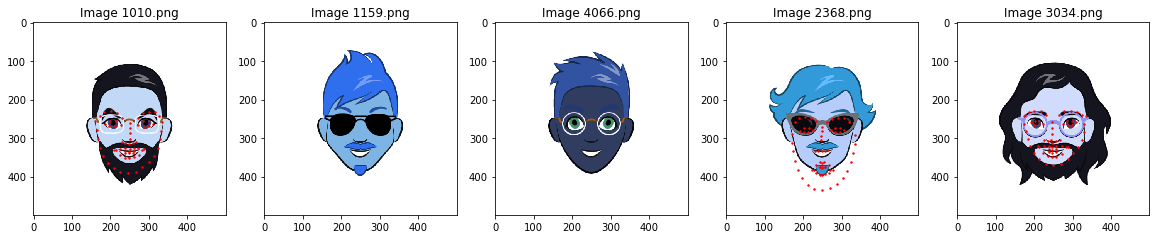

In [6]:
example_image = ['1010.png','1159.png','4066.png','2368.png','3034.png']
img_list = []
img_id = 1
fig = plt.figure(figsize = (20,20))

for example_img in example_image:
    path = os.path.join(images_dir, example_img)
    ex_img = image.img_to_array(image.load_img(path, target_size = None, interpolation='bicubic'))
    ex_feat,_ = run_dlib_shape(ex_img)
    cv_img = cv2.imread(path)
    
    a=fig.add_subplot(1, len(example_image), img_id)
    image_plot = plt.imshow(cv_img)
    a.set_title("Image " + example_img)
    img_id = img_id+1
    
    if ex_feat is not None:
        x,y = np.split(ex_feat, 2, axis=1)
        plt.scatter(x,y,c='red', s=2)

plt.show()

Image 1010 can detect pretty well regardless of the beard. Image 1159 cant be detect due to glasses. Image 4066 perfectly fine but feature extraction cant detect. Image 2368 detect facial completely wrong. Image 3034 ignore the beard and take the jawline where it is visible.

## Using CNN from Keras

### Convert labels to dataframe
This is to use for dataflow_from_dataframe

In [112]:
labels_file = open(labels_dir,'r')
lines = labels_file.readlines()
## Convert 0-4 to 1-5 and convert to string for categorical
fshape_labels = {line.split('\t')[3].split("\n")[0] : str(int(line.split('\t')[2])+1) for line in lines[1:]} 
df=pd.DataFrame(list(fshape_labels.items()))
df.columns = ['Filename', 'FaceShape']

In [113]:
print(df.head())

  Filename FaceShape
0    0.png         5
1    1.png         5
2    2.png         4
3    3.png         1
4    4.png         3


### Print labels count for each labels

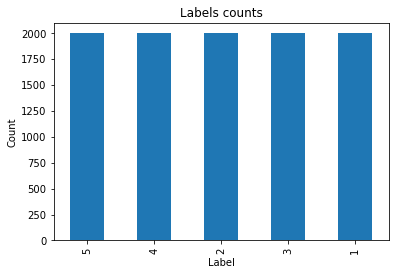

In [114]:
df.FaceShape.value_counts().plot(kind='bar')
plt.title('Labels counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

### Get Data

In [115]:
train_df, test_df = train_test_split(df, random_state=24)

In [118]:
print("Getting Data..")
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.25,horizontal_flip=True,vertical_flip=True)

print("Preparing training dataset..")
train_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=images_dir, x_col="Filename", y_col="FaceShape", class_mode="categorical", target_size=(32,32), batch_size=32, subset = 'training')

print("Preparing validation dataset..")
validation_generator = datagen.flow_from_dataframe(dataframe=train_df, directory=images_dir, x_col="Filename", y_col="FaceShape", class_mode="categorical", target_size = (32,32), batch_size=32, subset= 'validation')

print("Preparing testing dataset..")
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(dataframe=test_df, directory=images_dir, x_col="Filename", y_col="FaceShape", class_mode="categorical", target_size = (32,32), batch_size=32, shuffle=False)

Getting Data..
Preparing training dataset..
Found 5625 validated image filenames belonging to 5 classes.
Preparing validation dataset..
Found 1875 validated image filenames belonging to 5 classes.
Preparing testing dataset..
Found 2500 validated image filenames belonging to 5 classes.


### Define CNN layers

In [119]:

model = Sequential()

model.add(Conv2D(24, (3,3), input_shape=train_generator.image_shape))
model.add(Activation("relu"))

model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(24, (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(48, (3,3)))
model.add(Activation("relu"))

model.add(Conv2D(96, (3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(5))
model.add(Activation("softmax"))

opt = optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 30, 30, 24)        672       
_________________________________________________________________
activation_6 (Activation)    (None, 30, 30, 24)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 24)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 13, 13, 24)        5208      
_________________________________________________________________
activation_7 (Activation)    (None, 13, 13, 24)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 48)        10416     
_________________________________________________________________
activation_8 (Activation)    (None, 11, 11, 48)        0         
__________

### Training the Model

In [120]:
num_epochs = 25
batch_size = 32
history = model.fit_generator(train_generator, steps_per_epoch = train_generator.samples // batch_size, validation_data = validation_generator, validation_steps = validation_generator.samples // batch_size, epochs = num_epochs)

Epoch 1/25
175/175 [==============================] - 54s 310ms/step - loss: 1.6040 - acc: 0.2188 - val_loss: 1.5230 - val_acc: 0.3513
Epoch 2/25
175/175 [==============================] - 56s 319ms/step - loss: 0.2708 - acc: 0.9064 - val_loss: 0.2129 - val_acc: 0.9322
Epoch 5/25
175/175 [==============================] - 56s 318ms/step - loss: 0.2088 - acc: 0.9304 - val_loss: 0.1765 - val_acc: 0.9392
Epoch 6/25
175/175 [==============================] - 56s 319ms/step - loss: 0.1502 - acc: 0.9527 - val_loss: 0.1438 - val_acc: 0.9506
Epoch 7/25
175/175 [==============================] - 56s 319ms/step - loss: 0.1278 - acc: 0.9558 - val_loss: 0.1423 - val_acc: 0.9544
Epoch 8/25
175/175 [==============================] - 56s 321ms/step - loss: 0.1132 - acc: 0.9599 - val_loss: 0.1261 - val_acc: 0.9517
Epoch 9/25
175/175 [==============================] - 56s 321ms/step - loss: 0.0946 - acc: 0.9655 - val_loss: 0.0926 - val_acc: 0.9680
Epoch 10/25
175/175 [==============================] - 

### Viewing Loss History

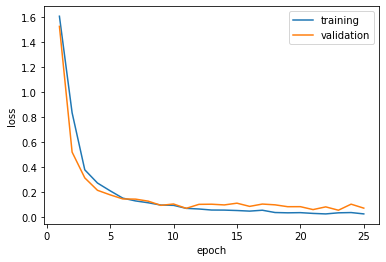

In [121]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

### View Model Performance

Generating predictions from validation data..


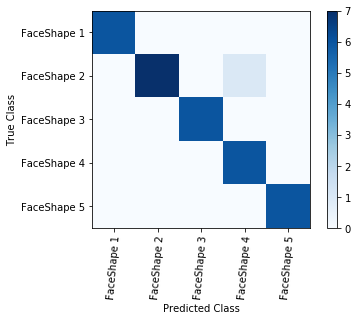

In [123]:
print("Generating predictions from validation data..")

x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

class_probabilities = model.predict(x_test)

predictions = np.argmax(class_probabilities, axis=1)

true_labels = np.argmax(y_test, axis=1)

classes = ["FaceShape 1", "FaceShape 2", "FaceShape 3", "FaceShape 4" , "FaceShape 5"]

cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes , rotation=85)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

In [ ]:
pred = class_probabilities
real = y_test

acc = accuracy_score(real, pred)
rec = recall_score(real, pred)
pre = precision_score(real,pred)
f1 = f1_score(real,pred)
print("Accuracy :" + str(acc))
print("Precision :" + str(pre))
print("Recall :" + str(rec))
print("F1 Score :" + str(f1))

## IGNORE CODE BELOW

In [88]:
print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.3)

print("Preparing training dataset...")
train_generator = datagen.flow_from_dataframe(dataframe=df, directory=images_dir, x_col="Filename", y_col="FaceShape", class_mode="raw", target_size=(32,32), batch_size=32, subset = 'training')

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_dataframe(dataframe=df, directory=images_dir, x_col="Filename", y_col="FaceShape", class_mode="raw", targe_size = (32,32), batch_size=32, subset= 'validation')

# classes = sorted(train_generator.class_indices.keys())
# print("classification name: ", classes)

Getting Data...
Preparing training dataset...
Found 7000 validated image filenames.
Preparing validation dataset...
Found 3000 validated image filenames.


In [7]:
def crop_img(file_dir): ## Crop to get only jawline/faceshape
    orig = cv2.imread(file_dir)
    crop = orig[280:400 , 150:350]
    return crop

def getdata_CNN(images_dir, labes_dir):
    image_paths = [os.path.join(images_dir, l) for l in os.listdir(images_dir)]
    labels_file = open(labels_dir, 'r')
    lines = labels_file.readlines()
    fshape_labels = {line.split('\t')[0] : int(line.split('\t')[2]) for line in lines[1:]}
    all_data = []
    data_name = []
    all_labels = []
    
    if os.path.isdir(images_dir):
        
        for img_path in image_paths:
            file_name = img_path.split('.')[0].split('\\')[-1]
            
            cropped = crop_img(img_path)
            cropped = cv2.resize(cropped, (28,28))
            datacrop = image.img_to_array(cropped)
            
            all_data.append(datacrop)
            data_name.append(file_name)
            all_labels.append(fshape_labels[file_name])
            
    data = np.array(all_data, dtype="float") /255.0
    label = np.array(all_labels)
    
    return data, label

data_CNN, label_CNN = getdata_CNN(images_dir, labels_dir)

### Splitting Data into Training and Testing

In [9]:
def split_data_CNN(image_feature, image_label):
    k = int(len(x)*(80/100))
    
    train_image = image_feature[:k]
    train_label = image_label[:k]
    
    test_image = image_feature[k:]
    test_label = image_label[k:]
    
#     i,j,k,l = train_test_split(image_feature, image_label, test_size = 0.2, random_state=42)
#     train_image = i.reshape((len(i), 68*2))
# #     train_image = i
#     train_label = totuple(k)
#     test_image = j.reshape((len(j), 68*2))
# #     test_image = j
#     test_label = totuple(l)
    
    return train_image, train_label, test_image, test_label

tr_imgCNN, tr_labCNN, te_imgCNN, te_labCNN = split_data_CNN(data_CNN, label_CNN)

### Separating Training and Validation

In [10]:
train_imageCNN, train_labelCNN, val_imgCNN, val_labCNN = split_data_CNN(tr_imgCNN, tr_labCNN)